In [1]:
# importing required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import os
import sys
import matplotlib.pyplot as plt

In [2]:
# downloading the data
batch_size_train = 64
batch_size_test = 50
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))])),
            batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))])),
            batch_size=batch_size_test, shuffle=True)


In [3]:
# defining the network
class Net(nn.Module):
    def __init__(self, width, p, k):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, width)
        self.mask = torch.ones(()).new_empty(k, width, requires_grad = False).bernoulli_(1-p).div_(1-p).unsqueeze(2).to(device) # (k, width, 1)
        self.dropout = nn.Dropout(p)
        self.fc2 = nn.Linear(width, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        if not self.training:
            x = torch.cat((x.unsqueeze(0),(self.mask * x.T).permute(0,2,1)), dim=0) # (k+1, n, width)
        x = self.fc2(x) # (n, c) or (k+1, n, c)
        return F.log_softmax(x, dim=-1) # (n) or (k+1, n)



In [4]:
# the training function
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if (epoch==1 and batch_idx in test_log_intervals) or (batch_idx and batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        if (epoch==1 and batch_idx in test_log_intervals) or (batch_idx and batch_idx % test_log_interval == 0):
            test_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            test(num_sparse)
        network.train()
    test_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    test(num_sparse)
    if drop_rate == 0.8 and width in [5000, 1000, 100]:
            model_name = './results/sparse/model_lr=%f_rate=%f_width=%d_run=%d.pt'%(learning_rate, drop_rate, width, run)
            optim_name = './results/sparse/optim_lr=%f_rate=%f_width=%d_run=%d.pt'%(learning_rate, drop_rate, width, run)
            torch.save(network.state_dict(), model_name)
            torch.save(optimizer.state_dict(), optim_name)


# the test function
def test(num_sparse=1):
    # at least 1 sparsenet + original net
    network.eval()
    test_loss = [0] * (num_sparse+1)
    correct = [0] * (num_sparse+1)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss = [test_loss[i] + F.nll_loss(output[i], target, size_average=False).item() for i in range(num_sparse+1)]
            pred = [output[i].data.max(1, keepdim=True)[1] for i in range(num_sparse+1)]
            correct = [correct[i] + pred[i].eq(target.data.view_as(pred[i])).sum() for i in range(num_sparse+1)]

            # correct = [correct[i] + (pred[i]==target.data).sum() for i in range(num_sparse+1)]

    test_loss = [test_loss[i]/len(test_loader.dataset) for i in range(num_sparse+1)]
    acc = [100. * correct[i] / len(test_loader.dataset) for i in range(num_sparse+1)]
    test_losses.append(test_loss)
    test_acc.append(acc)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss[0], correct[0].data, len(test_loader.dataset), acc[0]))


In [5]:
# cuda?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initializing parameters
lrs = [0.01]
drop_rates = [0.4]
wide = sys.argv[2]
widths = [10000]
n_epochs = 5
momentum = 0.0
log_interval = 25
test_log_interval = 200
test_log_intervals = [1, 10, 25, 50, 100, 150, 200, 300, 500]
num_sparse = 25
run = 0
random_seed = run + 1

In [6]:
# main loop
for learning_rate in lrs:
    for drop_rate in drop_rates:
        for width in widths:
            torch.manual_seed(random_seed)
            print('run = %d, width = %d, rate = %f, lr = %f'%(run, width, drop_rate, learning_rate))
            if not os.path.exists('./results/sparse/'):
                os.makedirs('./results/sparse/')            
            file_name = './results/sparse/stats_lr=%f_rate=%f_width=%d_run=%d.pt'%(learning_rate, drop_rate, width, run)
            if os.path.isfile(file_name):
                result_dict = torch.load(file_name)
                train_losses = result_dict['train_losses']
                test_losses = result_dict['test_losses']
                test_acc = result_dict['test_acc']
                test_counter = result_dict['test_counter']
                print('%s already exists'%file_name)
                continue
            
            train_losses, test_losses, test_acc, train_counter, test_counter = [], [], [], [], []

            network = Net(width, drop_rate, num_sparse)
            network.to(device)
            optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

            for epoch in range(1, n_epochs + 1):
                train(epoch)

            torch.save({'train_counter': train_counter,
                        'train_losses': train_losses,
                        'test_counter': test_counter,
                        'test_losses': test_losses,
                        'test_acc': test_acc}, file_name)


run = 0, width = 10000, rate = 0.400000, lr = 0.010000
Train Epoch: 1 [64/60000 (0%)]	Loss: 2.346913


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2968, Accuracy: 1610/10000 (16.1%)

Train Epoch: 1 [640/60000 (1%)]	Loss: 2.160261

Test set: Avg. loss: 2.1527, Accuracy: 3931/10000 (39.3%)

Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.753773

Test set: Avg. loss: 1.7632, Accuracy: 5318/10000 (53.2%)

Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.199872

Test set: Avg. loss: 1.0328, Accuracy: 7084/10000 (70.8%)

Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.628229
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.694457

Test set: Avg. loss: 0.5678, Accuracy: 8097/10000 (81.0%)

Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.727102
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.546997

Test set: Avg. loss: 0.3797, Accuracy: 8842/10000 (88.4%)

Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.453799
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.252149

Test set: Avg. loss: 0.3061, Accuracy: 9101/10000 (91.0%)

Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.178548
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.346463
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0

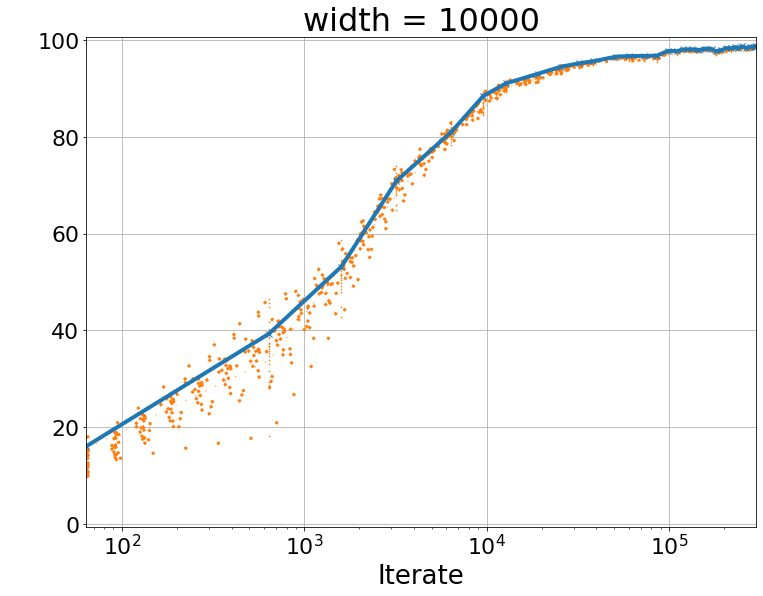

In [8]:
sub_rate = 1

# main loop
for learning_rate in lrs:
    for drop_rate in drop_rates:
        for width in widths:
            file_name = './results/sparse/stats_lr=%f_rate=%f_width=%d_run=%d.pt'%(learning_rate, drop_rate, width, run)
            result_dict = torch.load(file_name, map_location=torch.device('cpu'))
            train_losses = result_dict['train_losses']
            test_losses = result_dict['test_losses']
            test_acc = result_dict['test_acc']
            test_counter = result_dict['test_counter']
            sub_test_counter = [item for idx, item in enumerate(test_counter) if idx % sub_rate == 0]
            plt.close()
            plt.figure(figsize=(12,9))

            if not os.path.exists('./plots/'):
                os.makedirs('./plots/')            
            plot_name = './plots/acc_iter_allsparse_lr=%f_rate=%f_width=%d_run=%d.pdf'%(learning_rate, drop_rate, width, run)

#             plt.plot(test_counter, [test_acc[j][1] for j in range(len(test_acc))], color='gainsboro', marker='x', markersize=1, linestyle='dotted', linewidth=.1, label="sub-networks")
            test_accs = [test_acc[j][1] for j in range(len(test_acc))]
            sub_test_accs = [item for idx, item in enumerate(test_accs) if idx % sub_rate == 0]
            plt.plot(test_counter, test_accs, color='#ff7f0e', marker='x', markersize=1, linewidth=1, linestyle=(0, (1, 10)), label="sub-networks")


            for i in range(2,num_sparse+1):
#                 plt.plot(test_counter, [test_acc[j][i] for j in range(len(test_acc))], color='gainsboro', marker='x', markersize=1, linestyle='dotted', linewidth=.1)
                test_accs = [test_acc[j][i] for j in range(len(test_acc))]
                sub_test_accs = [item for idx, item in enumerate(test_accs) if idx % sub_rate == 0]
                plt.plot(test_counter, test_accs, color='#ff7f0e', marker='x', markersize=1, linestyle=(0, (1, 10)), linewidth=3)

#             plt.plot(test_counter, [test_acc[j][0] for j in range(len(test_acc))], color='#ff7f0e', marker='x', linewidth=4, label="full network")

            plt.plot(test_counter, [test_acc[j][0] for j in range(len(test_acc))], color='#1f77b4', marker='x', linewidth=4, label="full network")



            ax = plt.gca()
            ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
            plt.xlim((test_counter[0],test_counter[-1]))
            plt.ylim((-.5,100.5))
            if width == 100:
                plt.ylabel('Test Accuracy', fontsize=26)
            else:
                plt.ylabel(' ', fontsize=26)
            if width == 100:
                plt.legend(prop={'size': 26})
            plt.xlabel('Iterate', fontsize=26)
#             plt.title(r'width = %d, $p = %.1f$'%(width, drop_rate), fontsize=24)

            plt.title(r'width = %d'%(width), fontsize=32)

            # plt.yscale('log')
            plt.xscale('log')
            plt.grid()
            plt.savefig(plot_name, bbox_inches='tight')
            plt.show()